In [1]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import random as rd

C:\Users\ronak\anaconda3\envs\first\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [3]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train", "validation"],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True)

In [4]:
class_names = ds_info.features["label"].names

In [5]:
# viusalizing how our data looks
for image, label in train_data.take(1):
        pass
def visualise_data(dataset):
    for image, label in dataset.take(1):
        pass
    print(f"shape: {image.shape}")
    print(f"datatype: {image.dtype}")
    plt.imshow(image)
    plt.title(class_names[label.numpy()])
    plt.axis(False)

shape: (512, 384, 3)
datatype: <dtype: 'uint8'>


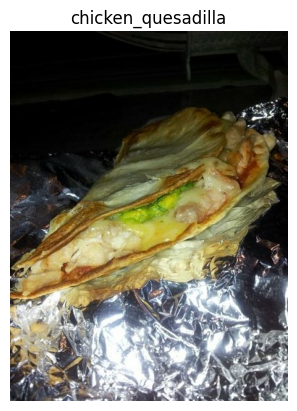

In [6]:
visualise_data(train_data)

In [7]:
# time to preprocess the data
from skimage.transform import resize
from sklearn.preprocessing import FunctionTransformer as ft

def preprocess_img(image, label, img_shape=224):
    # uint8 -> float32
    # shape: [img_shape, img_shape]
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [8]:
preprocess_img(image, label)[0] 

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[194.12755, 174.12755, 149.12755],
        [204.66325, 184.66325, 159.66325],
        [198.20918, 180.42348, 158.85204],
        ...,
        [200.12253, 186.55106, 160.97958],
        [204.22949, 190.22949, 164.22949],
        [195.14168, 179.14168, 154.14168]],

       [[197.10204, 177.10204, 150.10204],
        [202.5102 , 185.5102 , 159.5102 ],
        [209.96428, 193.83673, 169.47958],
        ...,
        [201.301  , 187.72952, 162.15805],
        [207.8622 , 193.8622 , 167.8622 ],
        [197.218  , 183.218  , 157.218  ]],

       [[192.0153 , 175.44388, 147.2296 ],
        [202.11224, 185.32652, 159.32652],
        [209.37755, 193.59183, 169.0204 ],
        ...,
        [205.13773, 191.28563, 167.99481],
        [208.99998, 194.99998, 168.99998],
        [201.62102, 187.62102, 161.62102]],

       ...,

       [[227.88795, 220.10222, 201.31648],
        [236.76028, 228.18881, 212.8623 ],
        [231.43372, 221.862

In [9]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# shuffling and batching train data 
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# shuffling and batching train data 
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE).cache()


In [10]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [11]:
checkpoint_path = "model_checkpoint.cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor="val_acc",
                                                     verbose=0,
                                                     save_best_only=True,
                                                     save_weights_only=True)

In [12]:
# enabling mixed precision training  
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


In [13]:
## building feature extracting model
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

In [14]:
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_shape") 
x = base_model(inputs, training=False)
x = tf.cast(x, dtype=tf.float32)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# compile
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(lr=0.01),
             metrics=["accuracy"])

C:\Users\ronak\anaconda3\envs\first\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False


In [16]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=5,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[model_checkpoint])


Epoch 1/5
2368/2368 [==============================] - 129s 50ms/step - loss: 2.2070 - accuracy: 0.5605 - val_loss: 1.7607 - val_accuracy: 0.6412
Epoch 2/5
2368/2368 [==============================] - 113s 47ms/step - loss: 1.7676 - accuracy: 0.6553 - val_loss: 1.7832 - val_accuracy: 0.6721
Epoch 3/5
2368/2368 [==============================] - 114s 48ms/step - loss: 1.5972 - accuracy: 0.6870 - val_loss: 1.8734 - val_accuracy: 0.6695
Epoch 4/5
2368/2368 [==============================] - 117s 49ms/step - loss: 1.4677 - accuracy: 0.7139 - val_loss: 2.0049 - val_accuracy: 0.6785
Epoch 5/5
2368/2368 [==============================] - 119s 50ms/step - loss: 1.3740 - accuracy: 0.7315 - val_loss: 2.0878 - val_accuracy: 0.6788


In [19]:
import os

save_dir = "food101_model"
model.save(save_dir)

In [20]:
loaded_saved_model = tf.keras.models.load_model(save_dir)